(https://keras.io/examples/nlp/text_extraction_with_bert/) 

In [45]:
import matplotlib.pyplot as plt
import os
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
from tensorflow import keras
from tensorflow.keras import layers
from transformers import BertTokenizer, TFBertModel, BertConfig, BertTokenizerFast 
print(tf.__version__)

2.4.1


In [46]:
labels = [
"Reductio ad hitlerum",
"Whataboutism",
"Presenting Irrelevant Data (Red Herring)",
"Doubt",
"Slogans",
"Appeal to fear/prejudice",
"Obfuscation, Intentional vagueness, Confusion",
"Misrepresentation of Someone's Position (Straw Man)",
"Glittering generalities (Virtue)",
"Appeal to authority",
"Repetition",
"Bandwagon",
"Causal Oversimplification",
"Name calling/Labeling",
"Thought-terminating cliché",
"Flag-waving",
"Exaggeration/Minimisation",
"Smears",
"Loaded Language",
"Black-and-white Fallacy/Dictatorship"
]

In [47]:
sep_train_pd = pd.read_csv("data.csv")

In [49]:
sep_train_pd

,text,prop_mask,technique
0,THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,Black-and-white Fallacy/Dictatorship
1,SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,Slogans
2,SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...,[0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0...,Name calling/Labeling
3,SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,Loaded Language
4,SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,Smears
...,...,...,...
7320,“Policies like background checks on all gun sa...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,Slogans
7321,The group also passed a resolution backing red...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,Repetition
7322,“Policies like background checks on all gun sa...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,Repetition
7323,“The U.S. Conference of Mayors will continue d...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,Flag-waving


In [50]:
def make_list(x):
    x = x[1:-1].split()
    x = list(map(int, x))
    return x

sep_train_pd["prop_mask"] = sep_train_pd["prop_mask"].apply(lambda x: make_list(x))

In [51]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")

In [54]:
def preprocessing(data, max_len=250):
    col_input_ids = []
    col_attention_mask = []
    col_token_type_ids = []
    col_token_prop_mask = []
    
    for i in range(data.shape[0]):
        token_text = tokenizer.encode_plus(
            data["text"][i], 
            return_offsets_mapping=True,
            max_length=max_len,
            truncation=True
        )
        
        token_count = len(token_text.input_ids)
        token_prop_mask = [0] * max_len
        for j, (ind_s, ind_e) in enumerate(token_text.offset_mapping):
            if sum(data["prop_mask"][i][ind_s:ind_e]) > 0:
                #print(data["text"][i][ind_s:ind_e], 109)
                token_prop_mask[j] = 1
            
        col_token_prop_mask.append(token_prop_mask) 

        token_technique = tokenizer.encode_plus(
            data["technique"][i], 
            return_offsets_mapping=True, 
            max_length=max_len, 
            truncation=True
        )

        input_ids = token_text.input_ids + token_technique.input_ids[1:]
        token_type_ids = [0] * token_count + [1] * len(token_technique.input_ids[1:])
        len_input_ids = len(input_ids)
        attention_mask = [1] * len_input_ids

        assert max_len > len_input_ids, f"max_len {max_len} <= len_input_ids {len_input_ids}"
        
        padding = [0] * (max_len - len_input_ids)
        col_input_ids.append(input_ids + padding)
        col_attention_mask.append(attention_mask + padding)
        col_token_type_ids.append(token_type_ids + padding)

        #if sum(token_prop_mask) > 0:
        #    print(data["technique"][i])
        #    print(data["text"][i])
        #    inp_ids = np.array(input_ids + padding)
        #    mask_ids = np.array(token_prop_mask)
        #    np_text = np.array(list(data["text"][i]))
        #    np_prop = np.array(data["prop_mask"][i])
        #    my_tok = inp_ids[mask_ids == 1] 
        #    prop_mask = data["prop_mask"][i]
        #    print("|", "".join(np_text[np_prop == 1]), "|")
        #    print(tokenizer.decode(my_tok))
        #    return
        
    return col_input_ids, col_attention_mask, col_token_type_ids, col_token_prop_mask

In [55]:
col_input_ids, col_attention_mask, col_token_type_ids, col_token_prop_mask = preprocessing(sep_train_pd)
sep_train_pd["col_input_ids"] = col_input_ids
sep_train_pd["col_attention_mask"] = col_attention_mask
sep_train_pd["col_token_type_ids"] = col_token_type_ids
sep_train_pd["col_token_prop_mask"] = col_token_prop_mask

In [56]:
sep_train_pd

,text,prop_mask,technique,col_input_ids,col_attention_mask,col_token_type_ids,col_token_prop_mask
0,THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Black-and-white Fallacy/Dictatorship,"[101, 1175, 1132, 1178, 1160, 5772, 1116, 2130...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
1,SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Slogans,"[101, 1177, 1129, 4558, 1663, 9304, 2155, 3983...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...,"[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",Name calling/Labeling,"[101, 1177, 1129, 4558, 1663, 9304, 2155, 3983...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Loaded Language,"[101, 1177, 1129, 4558, 1663, 9304, 2155, 3983...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Smears,"[101, 1177, 1129, 4558, 1663, 9304, 2155, 3983...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...
7320,“Policies like background checks on all gun sa...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Slogans,"[101, 789, 5502, 1176, 3582, 15008, 1113, 1155...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7321,The group also passed a resolution backing red...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Repetition,"[101, 1103, 1372, 1145, 2085, 170, 6021, 4581,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7322,“Policies like background checks on all gun sa...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Repetition,"[101, 789, 5502, 1176, 3582, 15008, 1113, 1155...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7323,“The U.S. Conference of Mayors will continue d...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Flag-waving,"[101, 789, 1103, 190, 119, 188, 119, 3511, 110...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [57]:
dev_pd = pd.read_json("data1/dev_set_task2.txt")

texts, prop_mask, techniques = separation_of_topics(dev_pd)
sep_dev_pd = pd.DataFrame(np.array([texts, prop_mask, techniques]).T,
                            columns = ["text", "prop_mask", "technique"])
col_input_ids, col_attention_mask, col_token_type_ids, col_token_prop_mask = preprocessing(sep_dev_pd)
sep_dev_pd["col_input_ids"] = col_input_ids
sep_dev_pd["col_attention_mask"] = col_attention_mask
sep_dev_pd["col_token_type_ids"] = col_token_type_ids
sep_dev_pd["col_token_prop_mask"] = col_token_prop_mask

<ipython-input-57-e6ccef707bb5>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sep_dev_pd = pd.DataFrame(np.array([texts, prop_mask, techniques]).T,


In [58]:
sep_dev_pd

,text,prop_mask,technique,col_input_ids,col_attention_mask,col_token_type_ids,col_token_prop_mask
0,"JOE VERSUS THE VOLCANIC KREMLIN DON\n\n""WILL ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Loaded Language,"[101, 179, 7745, 6055, 1103, 12069, 180, 16996...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
1,"JOE VERSUS THE VOLCANIC KREMLIN DON\n\n""WILL ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Name calling/Labeling,"[101, 179, 7745, 6055, 1103, 12069, 180, 16996...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
2,Never thought l'd die fighting IRRESPONSIBLY R...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Exaggeration/Minimisation,"[101, 1309, 1354, 181, 112, 173, 2939, 2935, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,Never thought l'd die fighting IRRESPONSIBLY R...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Loaded Language,"[101, 1309, 1354, 181, 112, 173, 2939, 2935, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ..."
4,Never thought l'd die fighting IRRESPONSIBLY R...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Name calling/Labeling,"[101, 1309, 1354, 181, 112, 173, 2939, 2935, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...
118,Deceitful\nObnoxious\nNarcissist\nArrogant\nLy...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Loaded Language,"[101, 1260, 2093, 2875, 2365, 184, 1830, 2728,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
119,Deceitful\nObnoxious\nNarcissist\nArrogant\nLy...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Name calling/Labeling,"[101, 1260, 2093, 2875, 2365, 184, 1830, 2728,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
120,"Got 195,000 + Americans KILLED.\nFought scient...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Appeal to fear/prejudice,"[101, 1400, 18500, 117, 1288, 116, 1821, 26237...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
121,"Got 195,000 + Americans KILLED.\nFought scient...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Loaded Language,"[101, 1400, 18500, 117, 1288, 116, 1821, 26237...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [59]:
import torch.nn as nn

class Model(transformers.BertPreTrainedModel):
    def __init__(self, config, PATH):
        super(Model, self).__init__(config)
        self.bert = transformers.BertModel.from_pretrained(PATH)
        self.linear = nn.Linear(1024, 1)
        self.flatten = nn.Flatten()
        self.sigm = nn.Sigmoid()
    
    def forward(self, ids, mask, token_type_ids):
        embedding = self.bert(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        )[0]
        logits = self.linear(embedding)
        logits = self.flatten(logits)
        result = self.sigm(logits)
        return result

In [60]:
PATH = 'tune_model/squad2'

bert = transformers.BertModel.from_pretrained(PATH)
my_model = Model(bert.config, PATH)

In [61]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

optimizer = optim.SGD(my_model.parameters(), lr=1e-2)
criterion = nn.BCELoss()

In [62]:
import torch

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

dev

'cpu'

In [63]:
my_model.to(dev)
print(1)

1


In [64]:
import matplotlib.pyplot as plt

def hist_graph(model, i, line):
    #take data
    ids = torch.tensor([list(sep_dev_pd["col_input_ids"][i])]).to(dev)
    attention_mask = torch.tensor([list(sep_dev_pd["col_attention_mask"][i])]).to(dev)
    type_ids = torch.tensor([list(sep_dev_pd["col_token_type_ids"][i])]).to(dev)
    #take model
    model.eval()
    with torch.no_grad():
        ans_seq_tok = np.array(sep_dev_pd["col_input_ids"][i])
        output = model(ids, attention_mask, type_ids)
        ans_mask = (torch.squeeze(output, dim=1)[0]).cpu()
        plt.figure(figsize=(18,8))
        words = []
        end = 0
        for j in range(len(ans_seq_tok)):
            if ans_seq_tok[j] == 102:
                end = j
                break
            words += [tokenizer.decode(int(ans_seq_tok[j])) + "_" + str(j)]
        plt.hlines(line, xmin=0, xmax=end, color ='r')
        plt.plot(words, ans_mask[:end], drawstyle='steps-mid', label='steps-mid', color ='black')
    plt.show()

In [65]:
def text_check(model, i, line):
    #take data
    ids = torch.tensor([list(sep_dev_pd["col_input_ids"][i])]).to(dev)
    attention_mask = torch.tensor([list(sep_dev_pd["col_attention_mask"][i])]).to(dev)
    type_ids = torch.tensor([list(sep_dev_pd["col_token_type_ids"][i])]).to(dev)
    #take model
    model.eval()
    with torch.no_grad():
        output = model(ids, attention_mask, type_ids)
        ans_mask = (torch.squeeze(output, dim=1)[0] > line).cpu()
        if sum(ans_mask) > 0:
            print("technique:", sep_dev_pd["technique"][i])
            print("---")
            print("text:", sep_dev_pd["text"][i])
            print("---")
            ans_seq_tok = np.array(sep_dev_pd["col_input_ids"][i])[ans_mask == 1]
            print("ans:", tokenizer.decode(ans_seq_tok))
            print("---")
            ans_mask = np.array(sep_dev_pd["col_token_prop_mask"][i])
            ans_seq_tok = np.array(sep_dev_pd["col_input_ids"][i])[ans_mask == 1]
            print("true ans:", tokenizer.decode(ans_seq_tok))
            print("---")
            hist_graph(my_model, 0, line)
            plt.show()
            return True
        print("---")
        return False

technique: Loaded Language
---
text: JOE  VERSUS THE VOLCANIC KREMLIN DON

"WILL YOU SHUT UP, MAN?"

LORD OF THE LIES
---
ans: [CLS]
---
true ans: shut up lord of the lies
---


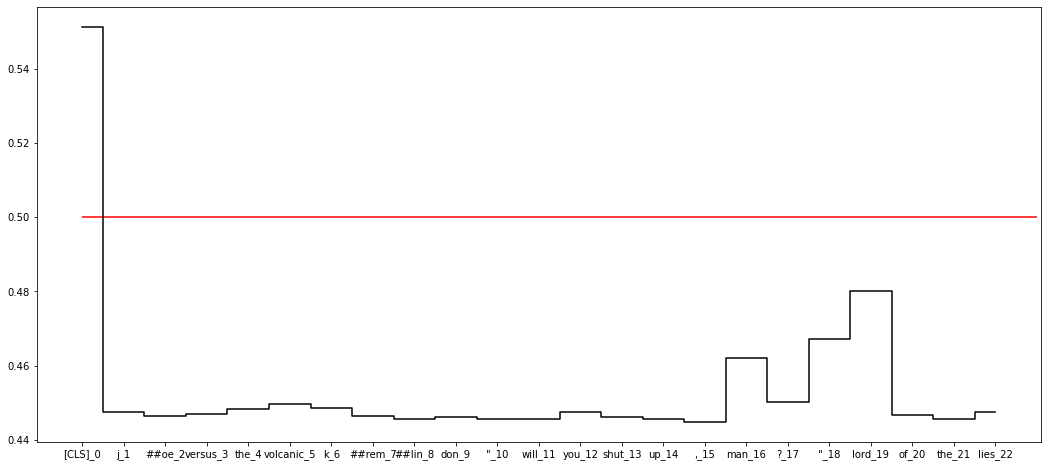

True

In [66]:
text_check(my_model, 0, 0.5) 

In [67]:
def check_metrics(model, data, line=0.5):
    batch_size = 10
    M = data.shape[0]
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    model.eval()
    with torch.no_grad():
        for i in range(0, M, batch_size):
            start = i
            end = i + batch_size if i + batch_size < M else M
            ids = torch.tensor(list(data["col_input_ids"][start:end])).to(dev)
            attention_mask = torch.tensor(list(data["col_attention_mask"][start:end])).to(dev)
            type_ids = torch.tensor(list(data["col_token_type_ids"][start:end])).to(dev)
            target = torch.tensor(list(data["col_token_prop_mask"][start:end]), dtype=torch.float).to(dev)
            
            output = my_model(ids, attention_mask, type_ids)
            output = (torch.squeeze(output, dim=1) > line).type(torch.int16)
            sum_tens = output + target
            diff_tens = output - target
            tp += (sum_tens == 2).sum().item()
            fp += (diff_tens == 1).sum().item()
            tn += (sum_tens == 0).sum().item()
            fn += (diff_tens == -1).sum().item()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    F = 2 * precision * recall / (precision + recall)
    print(f"precision={precision}, recall={recall}, accuracy={accuracy}, F={F}")
    return precision, recall, accuracy, F

In [28]:
import tqdm

EPOCHS = 4
batch_size = 5
dev_batch_size = 10
N = len(sep_train_pd)
M = len(sep_dev_pd)
data = sep_train_pd.values

precision = []
recall = []
accuracy = []
F = []

for epoch in range(EPOCHS):
    
    my_model.train()
    train_loss = 0
    for i in tqdm.tqdm(range(0, N, batch_size), leave=False):
        start = i
        end = i + batch_size if i + batch_size < N else N
        ids = torch.tensor(list(sep_train_pd["col_input_ids"][start:end])).to(dev)
        attention_mask = torch.tensor(list(sep_train_pd["col_attention_mask"][start:end])).to(dev)
        type_ids = torch.tensor(list(sep_train_pd["col_token_type_ids"][start:end])).to(dev)
        target = torch.tensor(list(sep_train_pd["col_token_prop_mask"][start:end]), dtype=torch.float).to(dev)
        
        optimizer.zero_grad()
        output = my_model(ids, attention_mask, type_ids)
        output = torch.squeeze(output, dim=1)
        loss = criterion(output, target * 0.99)
        train_loss += loss
        loss.backward()
        optimizer.step()
        
    dev_loss = 0
    check_metrics(my_model, sep_dev_pd, 0.5)
    my_model.eval()
    with torch.no_grad():
        for i in range(0, M, dev_batch_size):
            start = i
            end = i + dev_batch_size if i + dev_batch_size < M else M
            ids = torch.tensor(list(sep_dev_pd["col_input_ids"][start:end])).to(dev)
            attention_mask = torch.tensor(list(sep_dev_pd["col_attention_mask"][start:end])).to(dev)
            type_ids = torch.tensor(list(sep_dev_pd["col_token_type_ids"][start:end])).to(dev)
            target = torch.tensor(list(sep_dev_pd["col_token_prop_mask"][start:end]), dtype=torch.float).to(dev)
            
            output = my_model(ids, attention_mask, type_ids)
            output = torch.squeeze(output, dim=1)
            loss = criterion(output, target * 0.99)
            dev_loss += loss
        print(f"epoch {epoch}: train_loss = {train_loss}, dev_loss = {dev_loss}")

precision=0.725121359223301, recall=0.7104637336504162, accuracy=0.9402947154471545, F=0.7177177177177178


  0%|          | 0/237 [00:00<?, ?it/s]

epoch 0: train_loss = 33.466026306152344, dev_loss = 1.8760626316070557


precision=0.7587281795511222, recall=0.7235434007134364, accuracy=0.9458841463414634, F=0.740718198417529


  0%|          | 0/237 [00:00<?, ?it/s]

epoch 1: train_loss = 29.186553955078125, dev_loss = 1.6826038360595703


precision=0.7254366812227074, recall=0.7901307966706302, accuracy=0.945630081300813, F=0.7564029595902106


  0%|          | 0/237 [00:00<?, ?it/s]

epoch 2: train_loss = 26.498409271240234, dev_loss = 1.7217918634414673


precision=0.7599531615925058, recall=0.7717003567181926, accuracy=0.9495680894308943, F=0.7657817109144543


  0%|          | 0/237 [00:00<?, ?it/s]

epoch 3: train_loss = 23.96092414855957, dev_loss = 1.644991397857666


precision=0.7509771077610273, recall=0.7996432818073722, accuracy=0.950266768292683, F=0.7745465015836451
epoch 4: train_loss = 21.77276611328125, dev_loss = 1.5992634296417236


In [76]:
check_metrics(my_model, sep_dev_pd)

precision=0.23191489361702128, recall=0.06480380499405469, accuracy=0.8771595528455285, F=0.10130111524163568


In [ ]:
torch.save(my_model.state_dict(), "models/model.pth")